In [1]:
import tensorflow as tf
import tensorflow_hub as hub

import numpy as np
import matplotlib.pylab as plt

import datetime
import time

In [2]:
inception_v3 = "https://tfhub.dev/google/imagenet/inception_v3/classification/5"

classifier_model = inception_v3 #inception v3 selected as the pre-trained model from tensorflow hub

In [3]:
IMAGE_SHAPE = (299, 299)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_model, input_shape=IMAGE_SHAPE+(3,)) #wrapping the classifier as a Keras layer
])

In [4]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

In [5]:
###1 Reading and preparing the DataSet.

batch_size = 32
img_height = 299
img_width = 299

#loading the dataset from disk using "tf.keras.preprocessing.image_dataset_from_directory"
#dividing into training (80%) and validation (20%)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  'C:/Users/navil/Desktop/GuitarDatasetChallenge/',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  'C:/Users/navil/Desktop/GuitarDatasetChallenge/',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 95 files belonging to 2 classes.
Using 76 files for training.
Found 95 files belonging to 2 classes.
Using 19 files for validation.


In [6]:
class_names = np.array(train_ds.class_names) #checking class names
print(class_names)

['acoustic' 'electric']


In [7]:
# Use "tf.keras.layers.experimental.preprocessing.Rescaling" as the Tensorflow hub's for image models expect [0,1] range inputs.
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.

In [8]:
#use buffered prefetching to use the data from the disk with no I/O blocking issues.
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [9]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 299, 299, 3)
(32,)


In [10]:
#finally run the classifier against a group (batch) of images.
result_batch = classifier.predict(train_ds)

predicted_class_names = imagenet_labels[tf.math.argmax(result_batch, axis=-1)]
predicted_class_names

array(['acoustic guitar', 'acoustic guitar', 'acoustic guitar',
       'electric guitar', 'electric guitar', 'electric guitar',
       'acoustic guitar', 'acoustic guitar', 'electric guitar',
       'electric guitar', 'acoustic guitar', 'electric guitar',
       'acoustic guitar', 'electric guitar', 'electric guitar',
       'electric guitar', 'electric guitar', 'electric guitar',
       'acoustic guitar', 'electric guitar', 'electric guitar',
       'acoustic guitar', 'electric guitar', 'acoustic guitar',
       'acoustic guitar', 'acoustic guitar', 'acoustic guitar',
       'acoustic guitar', 'acoustic guitar', 'acoustic guitar',
       'electric guitar', 'acoustic guitar', 'acoustic guitar',
       'acoustic guitar', 'electric guitar', 'electric guitar', 'rule',
       'acoustic guitar', 'acoustic guitar', 'electric guitar',
       'acoustic guitar', 'electric guitar', 'electric guitar',
       'acoustic guitar', 'acoustic guitar', 'projector',
       'electric guitar', 'acoustic gu

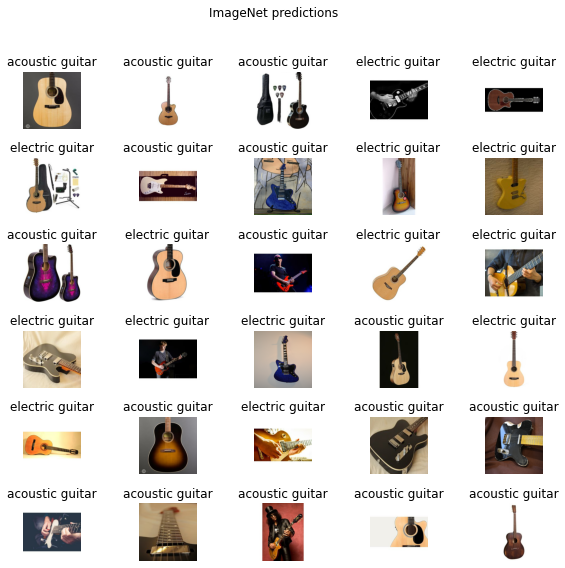

In [11]:
#check the predictions against the images.
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

In [12]:
###2 From here, training the "inception v3" classifier model using transfer learning with feature-extractor.

#TensorFlow Hub also distributes models without the top classification layer (headless model).
#These can be used to easily perform transfer learning.

inception_v3 = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"

feature_extractor_model = inception_v3

In [13]:
#Again use "hub.KerasLayer" to wrap the pre-trained model as a Keras Layer, so the feature extractor is created. 
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(299, 299, 3),
    trainable=False)

In [14]:
#2048-long vector for each image from the feature extractor.
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 2048)


In [15]:
num_classes = len(class_names)

#After wrapping the feature extractor layer in "tf.keras.Sequential" model and for classification a fully-connected
#layer is added to complete the model.
model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(num_classes)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 2048)              21802784  
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 21,806,882
Trainable params: 4,098
Non-trainable params: 21,802,784
_________________________________________________________________


In [16]:
predictions = model(image_batch)

predictions.shape

TensorShape([32, 2])

In [17]:
#Train the model by configuring the training process using "Model.compile" and add a callback,
#"tf.keras.callbacks.TensorBoard" to create and store logs.
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1) # Enable histogram computation for every epoch.

In [18]:
#Use "Model.fit" to train the model for 10 epochs.
#Create and store logs on TensorBoard callback to visualize the training progress.
#10 epochs is used as from 5th epoch the accuracy reaches 0.9474 and stays constant.
NUM_EPOCHS = 10

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=NUM_EPOCHS,
                    callbacks=tensorboard_callback)

Epoch 1/10
3/3 [==============================] - 20s 5s/step - loss: 0.9171 - acc: 0.3947 - val_loss: 0.7997 - val_acc: 0.4211
Epoch 2/10
3/3 [==============================] - 11s 4s/step - loss: 0.6690 - acc: 0.5658 - val_loss: 0.6615 - val_acc: 0.4211
Epoch 3/10
3/3 [==============================] - 11s 4s/step - loss: 0.4926 - acc: 0.7500 - val_loss: 0.4337 - val_acc: 0.8947
Epoch 4/10
3/3 [==============================] - 11s 4s/step - loss: 0.3666 - acc: 0.9474 - val_loss: 0.3450 - val_acc: 0.8947
Epoch 5/10
3/3 [==============================] - 12s 4s/step - loss: 0.2973 - acc: 0.9342 - val_loss: 0.2977 - val_acc: 0.9474
Epoch 6/10
3/3 [==============================] - 12s 4s/step - loss: 0.2270 - acc: 0.9605 - val_loss: 0.2739 - val_acc: 0.9474
Epoch 7/10
3/3 [==============================] - 11s 4s/step - loss: 0.1775 - acc: 0.9868 - val_loss: 0.2671 - val_acc: 0.8947
Epoch 8/10
3/3 [==============================] - 12s 4s/step - loss: 0.1496 - acc: 1.0000 - val_loss: 0

In [19]:
###3 From here, testing the customized "inception v3" model's performance.

#Check the predictions by fetching the ordered list of class names from model predictions.
predicted_batch = model.predict(image_batch)
predicted_id = tf.math.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]
print(predicted_label_batch)

['acoustic' 'acoustic' 'acoustic' 'electric' 'acoustic' 'acoustic'
 'electric' 'electric' 'acoustic' 'electric' 'acoustic' 'acoustic'
 'electric' 'acoustic' 'acoustic' 'electric' 'electric' 'electric'
 'acoustic' 'acoustic' 'acoustic' 'acoustic' 'electric' 'electric'
 'electric' 'electric' 'electric' 'electric' 'acoustic' 'acoustic'
 'acoustic' 'electric']


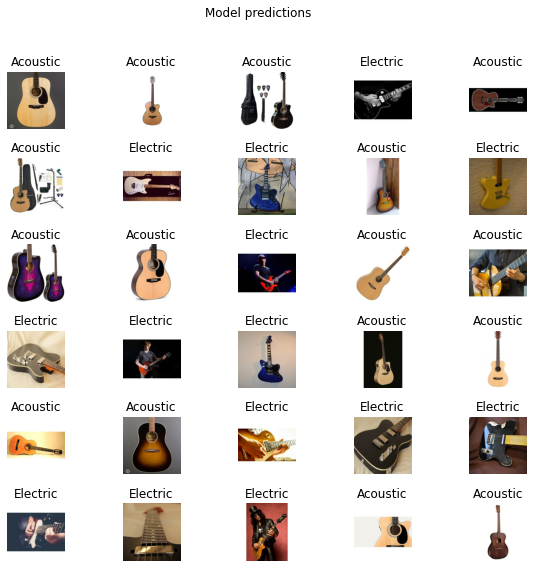

In [20]:
#Plot the model predictions.
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)

for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions")

In [21]:
#After training is complete, model is exported as a SavedModel to reuse later.
t = time.time()

export_path = "/tmp/saved_models/{}".format(int(t))
model.save(export_path)

export_path

INFO:tensorflow:Assets written to: /tmp/saved_models/1632734499\assets


INFO:tensorflow:Assets written to: /tmp/saved_models/1632734499\assets


'/tmp/saved_models/1632734499'

In [22]:
#Finally, check to see if the SavedModel can be reloaded and outputs the same results.
reloaded = tf.keras.models.load_model(export_path)

result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

abs(reloaded_result_batch - result_batch).max()

0.0

In [23]:
reloaded_predicted_id = tf.math.argmax(reloaded_result_batch, axis=-1)
reloaded_predicted_label_batch = class_names[reloaded_predicted_id]
print(reloaded_predicted_label_batch)

['acoustic' 'acoustic' 'acoustic' 'electric' 'acoustic' 'acoustic'
 'electric' 'electric' 'acoustic' 'electric' 'acoustic' 'acoustic'
 'electric' 'acoustic' 'acoustic' 'electric' 'electric' 'electric'
 'acoustic' 'acoustic' 'acoustic' 'acoustic' 'electric' 'electric'
 'electric' 'electric' 'electric' 'electric' 'acoustic' 'acoustic'
 'acoustic' 'electric']


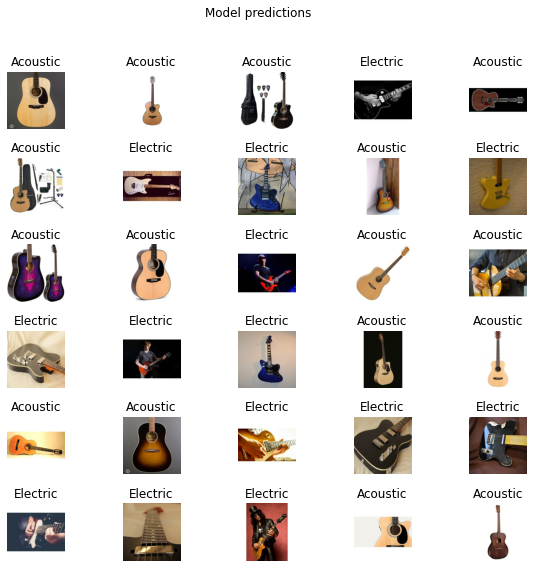

In [24]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(reloaded_predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions")